In [2]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

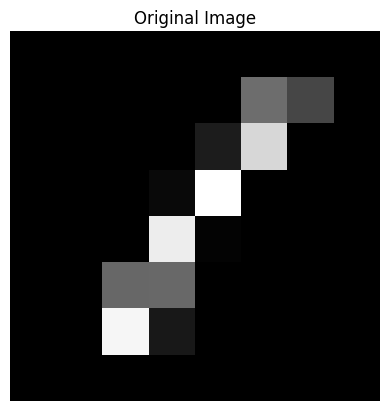

In [ ]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('mnist-resized neqr.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)


def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values):
    num_position_qubits = len(position_qubits)
    num_intensity_qubits = len(intensity_qubits)
    
    for idx, pixel in enumerate(pixel_values):
        
        # Convert index to binary (with leading zeros)
        bin_idx = format(idx, f'0{num_position_qubits}b')
        
        # Step 1: Apply X gates to "select" the current position
        x_qubits = [
            position_qubits[i] 
            for i, bit in enumerate(bin_idx) 
            if bit == '0'
        ]
        # Apply X gates one by one
        for q in x_qubits:
            circ.x(q)
        
        # Step 2: Encode intensity (binary value of the pixel)
        intensity_bin = format(pixel, f'0{num_intensity_qubits}b')
        for i, bit in enumerate(intensity_bin):
            if bit == '1':
                # Apply multi-controlled X gate (controls=position_qubits, target=intensity_qubits[i])
                circ.mcx(
                    control_qubits=position_qubits, 
                    target_qubit=intensity_qubits[i]
                )
        
        # Step 3: Uncompute X gates to reset position qubits
        for q in x_qubits:
            circ.x(q)


def encode_pixel_values_debug(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values_debug(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

In [29]:
import numpy as np
from qiskit_aer import AerSimulator

# 1) Pick a test index and value
test_idx   = 21    # any number 0–63
test_value = 200   # any 0–255

# 2) Build a one-hot pixel array
pv = np.zeros(64, dtype=int)
pv[test_idx] = test_value

# 3) Re-make your circuit with that array
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)
neqr(qc, position_qubits, intensity_qubits, pv)
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# 4) Run
sim = AerSimulator()
t_qc = transpile(qc, sim)
counts = sim.run(t_qc, shots=5000).result().get_counts()

# 5) Print only the non-zero outcomes
print("=== non-zero outcomes ===")
for bitstr, cnt in counts.items():
    int_bin = bitstr[:8]
    if int(int_bin,2) != 0:
        pos_bin = bitstr[8:]
        print(f"{bitstr} → intensity={int(int_bin,2)},"
              f" position={int(pos_bin,2)}, shots={cnt}")

# 6) Inside encode_pixel_values, add at top of loop:
#    (re-define or monkey-patch it temporarily)
def encode_pixel_values_debug(circ, pos_q, int_q, pixel_vals):
    n = len(pos_q)
    for idx, pixel in enumerate(pixel_vals):
        bin_idx = format(idx, f'0{n}b')
        if idx == test_idx:
            flips = [n-1-i for i,b in enumerate(bin_idx) if b=='0']
            print(f"Encoding idx={idx}, bin_idx={bin_idx}, flips → pos_qubits {flips}")
        # (then copy your existing intensity‐and‐uncompute logic…)

# 7) Rerun steps 3–5 with encode_pixel_values replaced by encode_pixel_values_debug.



=== non-zero outcomes ===
11001000010101 → intensity=200, position=21, shots=78


In [34]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
simulator = AerSimulator()

# Transpile the circuit for the simulator
t_qc = transpile(qc, simulator)

# Run the circuit on the simulator with 128 shots
num_shots = 10000
result = simulator.run(t_qc, shots=num_shots).result()

# Get the counts (measurement outcomes)
counts = result.get_counts()

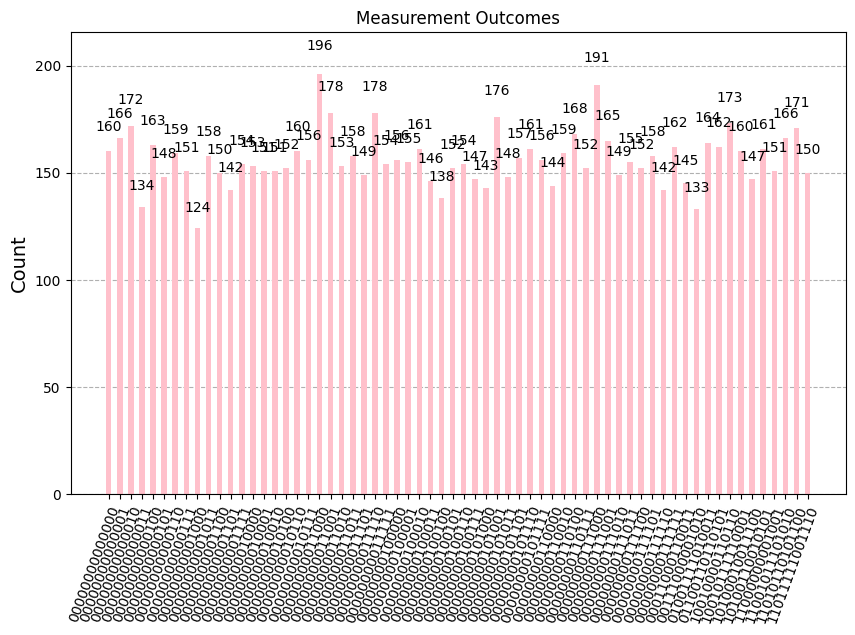

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axes
plot_histogram(simplified_counts, title="Measurement Outcomes", bar_labels=True, ax=ax, color="pink")  # Pass the axes to plot_histogram
plt.show()

Position 41 (binary 101001): Intensity binary 00000000, Intensity value 0
Position 8 (binary 001000): Intensity binary 00000000, Intensity value 0
Position 0 (binary 000000): Intensity binary 00000000, Intensity value 0
Position 55 (binary 110111): Intensity binary 00000000, Intensity value 0
Position 44 (binary 101100): Intensity binary 00000000, Intensity value 0
Position 52 (binary 110100): Intensity binary 00000000, Intensity value 0
Position 3 (binary 000011): Intensity binary 00000000, Intensity value 0
Position 46 (binary 101110): Intensity binary 00000000, Intensity value 0
Position 5 (binary 000101): Intensity binary 00000000, Intensity value 0
Position 50 (binary 110010): Intensity binary 00000000, Intensity value 0
Position 29 (binary 011101): Intensity binary 00000000, Intensity value 0
Position 13 (binary 001101): Intensity binary 00000000, Intensity value 0
Position 36 (binary 100100): Intensity binary 00000000, Intensity value 0
Position 60 (binary 111100): Intensity bin

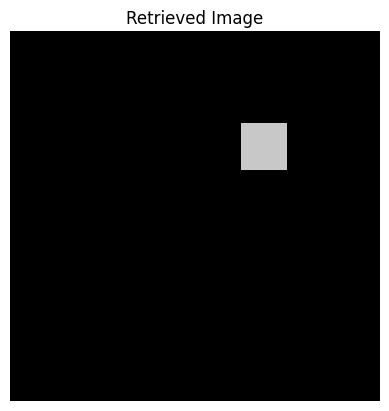

In [36]:
# Initialize an array to store the retrieved image
retrieve_image = np.zeros(64)

# Iterate over all keys in the counts dictionary
for key, count in counts.items():
    # Extract the 6-bit position and 8-bit intensity from the key
    position_binary = key[8:]  # First 6 bits are the position
    intensity_binary = key[:8]  # Last 8 bits are the intensity

    # Convert the position and intensity from binary to integers
    position = int(position_binary, 2)
    intensity = int(intensity_binary, 2)

    # Store the intensity value in the corresponding position
    retrieve_image[position] = intensity

    # Debug print for each position and intensity
    print(f"Position {position} (binary {position_binary}): Intensity binary {intensity_binary}, Intensity value {intensity}")

# Reshape the retrieved image to 8x8
retrieve_image = retrieve_image.reshape((8, 8)).astype(np.uint8)

# Plot the retrieved image
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()